## Making figure 6

Start by importing modules, data files and defining functions.

In [37]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.random as rand
import h5py

from makeCorner import *

az.rcParams["plot.max_subplots"] = 90

In [38]:
data_mass_variation = h5py.File("../data/mass_variation_analysis.hdf", "r")

In [40]:
def sigmoid_zp(low, high, width, middle, mass):
    return (high - low) / (1 + jnp.exp(-(1/width)*(mass - middle))) + low

def merger_rate_zp_sigmoid(alpha_z,high_alpha, width_alpha_z, middle_alpha_z,
                           beta_z, high_beta_z, width_beta_z, middle_beta_z,
                           low_zp, high_zp, width_m, m_middle, masses, z_s):
    alpha_z = sigmoid_zp(alpha_z, high_alpha, width_alpha_z, middle_alpha_z, masses)
    beta_z = sigmoid_zp(beta_z, high_beta_z, width_beta_z, middle_beta_z, masses)
    new_zp = sigmoid_zp(low_zp, high_zp, width_m, m_middle, masses)
    return (1+z_s)**alpha_z/(1+((1+z_s)/(1+new_zp))**(alpha_z+beta_z))

def computing_gaussian_prob(value, mean, std):
    return (1/(std * np.sqrt(2*np.pi))) * np.exp(-(value - mean)**2/(2.*std**2))

def computing_uniform_prob(a, b):
    return 1/(b-a)

m_grid = np.linspace(2,120,500)
masses = np.linspace(0,90, 5000)

### Computing prior samples

In [65]:
alpha_matrix = np.zeros((len(data_mass_variation['posterior/alpha_z']), len(masses)))

prior_alpha_z = rand.normal(0,4, np.size(data_mass_variation['posterior/alpha_ref']))
prior_high_alpha_z = rand.normal(0, 4, np.size(data_mass_variation['posterior/alpha_ref']))
prior_width_alpha_z = rand.uniform(-1,3, np.size(data_mass_variation['posterior/alpha_ref']))
prior_middle_alpha_z = rand.uniform(20, 75, np.size(data_mass_variation['posterior/alpha_ref']))

for i in range(len(data_mass_variation['posterior/alpha_ref'])):
    alpha_r = sigmoid_zp(prior_alpha_z[i],
                               prior_high_alpha_z[i],
                               10.**prior_width_alpha_z[i],
                               prior_middle_alpha_z[i],
                               masses,
                              )
    alpha_matrix[i, :] = alpha_r

alpha_median = np.median(alpha_matrix, axis = 0)
only_prior_alpha_median = alpha_median
only_prior_alpha_quantile_5 = np.quantile(alpha_matrix,0.05,axis=0)
only_prior_alpha_quantile_95 = np.quantile(alpha_matrix,0.95,axis=0)

In [66]:
beta_matrix = np.zeros((len(data_mass_variation['posterior/beta_z']), len(masses)))

prior_beta_z = rand.uniform(0,10, np.size(data_mass_variation['posterior/beta_z']))
prior_high_beta_z = rand.uniform(0, 10, np.size(data_mass_variation['posterior/beta_z']))
prior_width_beta_z = rand.uniform(-1,3, np.size(data_mass_variation['posterior/beta_z']))
prior_middle_beta_z = rand.uniform(20, 75, np.size(data_mass_variation['posterior/beta_z']))

for i in range(len(data_mass_variation['posterior/beta_z'])):
    beta_r = sigmoid_zp(prior_beta_z[i],
                               prior_high_beta_z[i],
                               10.**prior_width_beta_z[i],
                               prior_middle_beta_z[i],
                               masses,
                              )
    beta_matrix[i, :] = beta_r

beta_median = np.median(beta_matrix, axis = 0)
only_prior_beta_median = beta_median
only_prior_beta_quantile_5 = np.quantile(beta_matrix,0.05,axis=0)
only_prior_beta_quantile_95 = np.quantile(beta_matrix,0.95,axis=0)

In [68]:
zp_matrix = np.zeros((len(data_mass_variation['posterior/alpha_z']), len(masses)))

prior_zp_z = rand.uniform(0.2,4, np.size(data_mass_variation['posterior/alpha_ref']))
prior_high_zp_z = rand.uniform(0.2, 4, np.size(data_mass_variation['posterior/alpha_ref']))
prior_width_zp_z = rand.uniform(-1,3, np.size(data_mass_variation['posterior/alpha_ref']))
prior_middle_zp_z = rand.uniform(20, 75, np.size(data_mass_variation['posterior/alpha_ref']))

for i in range(len(data_mass_variation['posterior/alpha_ref'])):
    zp_r = sigmoid_zp(prior_zp_z[i],
                               prior_high_zp_z[i],
                               10.**prior_width_zp_z[i],
                               prior_middle_zp_z[i],
                               masses,
                              )
    zp_matrix[i, :] = zp_r

zp_median = np.median(zp_matrix, axis = 0)
only_prior_zp_median = zp_median
only_prior_zp_quantile_5 = np.quantile(zp_matrix,0.05,axis=0)
only_prior_zp_quantile_95 = np.quantile(zp_matrix,0.95,axis=0)

### Computing computational priors

First: alpha_z

In [70]:
error_tol = 1e-2
npts = np.size(data_mass_variation['posterior/alpha_z'][:])
brute_force_alpha_z_high = np.zeros(npts)
brute_force_alpha_z_low = np.zeros(npts)
brute_force_m_transition = np.zeros(npts)
brute_force_delta_m = np.zeros(npts)
m_ref = 35

for i in range(npts):
    
    close_enough = False
    posterior_value_m_35 = sigmoid_zp(
        data_mass_variation['posterior/alpha_z'][:][i],
        data_mass_variation['posterior/high_alpha_z'][:][i],
        data_mass_variation['posterior/width_alpha_z'][:][i],
        data_mass_variation['posterior/middle_m_alpha_z'][:][i],
        m_ref,
    )
    
    while not close_enough:
        
        # Draw a random set of hyperparameters from their original priors
        draw_alpha_z_low = np.random.normal(loc=0,scale=4)
        draw_alpha_z_high = np.random.normal(loc=0,scale=4)
        draw_m_transition = np.random.uniform(low=20,high=75)
        draw_log_delta_m = np.random.uniform(low=-1,high=3)
        draw_delta_m = 10.**draw_log_delta_m
        
        # Compute the sigmoid defined by these parameters and evaluate it at m_ref = 35
        sig_val = sigmoid_zp(draw_alpha_z_low, draw_alpha_z_high, draw_delta_m, draw_m_transition, m_ref)
        if np.abs(sig_val-posterior_value_m_35)<error_tol:
            
            # If we're sufficiently close to the target, save
            brute_force_alpha_z_high[i] = draw_alpha_z_high
            brute_force_alpha_z_low[i] = draw_alpha_z_low
            brute_force_m_transition[i] = draw_m_transition
            brute_force_delta_m[i] = draw_delta_m
            
            close_enough = True

Now: z_p

In [71]:
error_tol = 1e-2
npts = np.size(data_mass_variation['posterior/alpha_z'][:])
brute_force_zp_high = np.zeros(npts)
brute_force_zp_low = np.zeros(npts)
brute_force_m_transition_zp = np.zeros(npts)
brute_force_delta_m_zp = np.zeros(npts)
m_ref = 35

for i in range(npts):
    
    close_enough = False
    posterior_value_m_35 = sigmoid_zp(
        data_mass_variation['posterior/low_zp'][:][i],
        data_mass_variation['posterior/high_zp'][:][i],
        data_mass_variation['posterior/width_zp'][:][i],
        data_mass_variation['posterior/middle_m_zp'][:][i],
        m_ref,
    )
    
    while not close_enough:
        
        # Draw a random set of hyperparameters from their original priors
        draw_zp_low = np.random.uniform(low=0.2,high=4)
        draw_zp_high = np.random.uniform(low=0.2,high=4)
        draw_m_transition = np.random.uniform(low=20,high=75)
        draw_log_delta_m = np.random.uniform(low=-1,high=3)
        draw_delta_m = 10.**draw_log_delta_m
        
        # Compute the sigmoid defined by these parameters and evaluate it at m_ref = 35
        sig_val = sigmoid_zp(draw_zp_low, draw_zp_high, draw_delta_m, draw_m_transition, m_ref)
        if np.abs(sig_val-posterior_value_m_35)<error_tol:
            
            # If we're sufficiently close to the target, save
            brute_force_zp_high[i] = draw_zp_high
            brute_force_zp_low[i] = draw_zp_low
            brute_force_m_transition_zp[i] = draw_m_transition
            brute_force_delta_m_zp[i] = draw_delta_m
            
            close_enough = True

Ending with beta_z

In [72]:
error_tol = 1e-2
npts = np.size(data_mass_variation['posterior/alpha_z'][:])
brute_force_beta_high = np.zeros(npts)
brute_force_beta_low = np.zeros(npts)
brute_force_m_transition_beta = np.zeros(npts)
brute_force_delta_m_beta = np.zeros(npts)
m_ref = 35

for i in range(npts):
    
    close_enough = False
    posterior_value_m_35 = sigmoid_zp(
        data_mass_variation['posterior/beta_z'][:][i],
        data_mass_variation['posterior/high_beta_z'][:][i],
        data_mass_variation['posterior/width_beta_z'][:][i],
        data_mass_variation['posterior/middle_m_beta_z'][:][i],
        m_ref,
    )
    
    while not close_enough:
        
        # Draw a random set of hyperparameters from their original priors
        draw_beta_low = np.random.uniform(low=0,high=10)
        draw_beta_high = np.random.uniform(low=0,high=10)
        draw_m_transition = np.random.uniform(low=20,high=75)
        draw_log_delta_m = np.random.uniform(low=-1,high=3)
        draw_delta_m = 10.**draw_log_delta_m
        
        # Compute the sigmoid defined by these parameters and evaluate it at m_ref = 35
        sig_val = sigmoid_zp(draw_beta_low, draw_beta_high, draw_delta_m, draw_m_transition, m_ref)
        if np.abs(sig_val-posterior_value_m_35)<error_tol:
            
            # If we're sufficiently close to the target, save
            brute_force_beta_high[i] = draw_beta_high
            brute_force_beta_low[i] = draw_beta_low
            brute_force_m_transition_beta[i] = draw_m_transition
            brute_force_delta_m_beta[i] = draw_delta_m
            
            close_enough = True

In [73]:
brute_force_conditional_prior = np.array([sigmoid_zp(brute_force_alpha_z_low[i], brute_force_alpha_z_high[i], brute_force_delta_m[i], brute_force_m_transition[i], masses) 
                           for i in range(npts)])
brute_force_conditional_prior_zp = np.array([sigmoid_zp(brute_force_zp_low[i], brute_force_zp_high[i], brute_force_delta_m_zp[i], brute_force_m_transition_zp[i], masses) 
                           for i in range(npts)])
brute_force_conditional_prior_beta = np.array([sigmoid_zp(brute_force_beta_low[i], brute_force_beta_high[i], brute_force_delta_m_beta[i], brute_force_m_transition_beta[i], masses) 
                           for i in range(npts)])

### Making figure 6

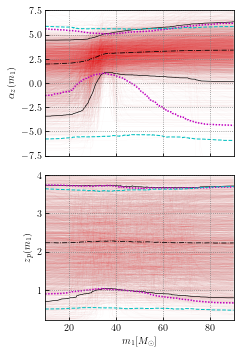

In [74]:
cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8.75*cm, 2*6.375*cm))

ax1.set_rasterization_zorder(2)

alpha_matrix_post = np.zeros((len(data_mass_variation['posterior/alpha_ref']), len(masses)))
low_value_z_matrix = np.zeros(len(data_mass_variation['posterior/alpha_ref']))
for i in range(len(data_mass_variation['posterior/alpha_z'])):
    alpha_r_post = sigmoid_zp(data_mass_variation['posterior/alpha_z'][:][i],
                               data_mass_variation['posterior/high_alpha_z'][:][i],
                               data_mass_variation['posterior/width_alpha_z'][:][i],
                               data_mass_variation['posterior/middle_m_alpha_z'][:][i],
                               masses,
                              )
    ax1.plot(masses, alpha_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    alpha_matrix_post[i, :] = alpha_r_post

median_alpha = np.nanmedian(alpha_matrix, axis = 0)
median_alpha_post = np.median(alpha_matrix_post, axis = 0)
ax1.set_ylim(-7.5, 7.5)
ax1.set_ylabel(r"$\alpha_z(m_1)$", fontsize = 10)
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(masses, median_alpha_post, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(masses,np.quantile(alpha_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses,np.quantile(alpha_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(masses, np.quantile(brute_force_conditional_prior, 0.05, axis=0), zorder = 1, color='m',  linestyle=(0,(1,1)))
ax1.plot(masses, np.quantile(brute_force_conditional_prior, 0.95, axis=0), zorder = 1, color='m',  linestyle=(0,(1,1)))
ax1.plot(masses, only_prior_alpha_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(masses, only_prior_alpha_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")


ax2.set_rasterization_zorder(2)
zp_matrix_post = np.zeros((len(data_mass_variation['posterior/alpha_ref']), len(masses)))
low_value_z_matrix = np.zeros(len(data_mass_variation['posterior/alpha_ref']))
for i in range(len(data_mass_variation['posterior/low_zp'])):
    zp_r_post = sigmoid_zp(data_mass_variation['posterior/low_zp'][:][i],
                               data_mass_variation['posterior/high_zp'][:][i],
                               data_mass_variation['posterior/width_zp'][:][i],
                               data_mass_variation['posterior/middle_m_zp'][:][i],
                               masses,
                              )
    plt.plot(masses, zp_r_post, lw = 0.05, color='#e31a1c', alpha = 0.2, zorder = 1)
    zp_matrix_post[i, :] = zp_r_post

median_zp = np.nanmedian(zp_matrix, axis = 0)
median_zp_post = np.median(zp_matrix_post, axis = 0)
ax2.set_xlim(10,90)
ax2.set_ylim(0.2, 4)
ax2.set_xlabel(r"$m_1 [M_\odot]$", fontsize = 10)
ax2.set_ylabel(r"$z_p(m_1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax2.plot(masses, median_zp_post, "-.", c="k", zorder = 1, lw = 0.8)
ax2.plot(masses,np.quantile(zp_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(masses,np.quantile(zp_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(masses, np.quantile(brute_force_conditional_prior_zp, 0.05, axis=0), zorder = 1, color='m',  linestyle=(0,(1,1)))
ax2.plot(masses, np.quantile(brute_force_conditional_prior_zp, 0.95, axis=0), zorder = 1, color='m',  linestyle=(0,(1,1)))
ax2.plot(masses, only_prior_zp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(masses, only_prior_zp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")

plt.setp(ax1.get_xticklabels(), visible=False)

# Adjust layout
plt.tight_layout()
plt.savefig("figure_6.pdf", dpi=500, bbox_inches="tight")
plt.show()